In [1]:
from datetime import datetime, timedelta
import json

import matplotlib.pyplot as plt
import numpy as np

from intervaltree import IntervalTree, Interval
from iso8601 import parse_date

In [2]:
observations = json.load(open('observations.json'))

In [3]:
tree = IntervalTree()

# count the bad obs start/end times
non_causal = 0
zero_duration = 0
for o in observations.values():
    start = parse_date(o['start'], default_timezone=None)
    end = parse_date(o['end'], default_timezone=None)
    
    # ignore bogus start/end times
    if end < start:
        non_causal += 1
        continue
    elif end == start:
        zero_duration += 1
        continue
    tree.addi(start, end, o)

print(zero_duration, 'zero duration')
print(non_causal, 'start > end')

66 zero duration
28 start > end


In [4]:
len(tree)

167815

In [5]:
firstday = tree.begin().replace(hour=0, minute=0, second=0)
lastday = tree.end().replace(hour=0, minute=0, second=0)


days = [firstday + timedelta(days=i) for i in range((lastday - firstday).days)]
len(days)

1002

In [6]:
total = []
good = []
bad = []
failed = []
unknown = []
duration = []
d = timedelta(seconds=0)

oneday = timedelta(days=1)
for i, day in enumerate(days):
    obs = tree[day : day + oneday]
    count = dict(total=0, good=0, bad=0, failed=0, unknown=0)
    d = timedelta(seconds=0)
    for o in obs:
        count[o.data['vetted_status']] += 1
        count['total'] += 1
        d += o.end - o.begin
    total.append(count['total'])
    good.append(count['good'])
    bad.append(count['bad'])
    failed.append(count['failed'])
    unknown.append(count['unknown'])
    duration.append(d)


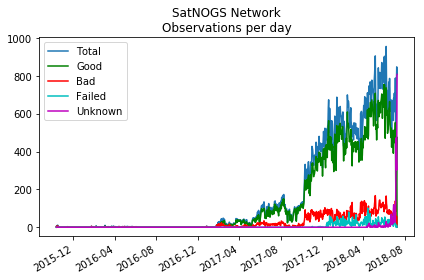

In [7]:
fig, ax = plt.subplots()

ax.plot(days, total, label='Total')
ax.plot(days, good, '-g', label='Good')
ax.plot(days, bad, '-r', label='Bad')
ax.plot(days, failed, '-c', label='Failed')
ax.plot(days, unknown, '-m', label='Unknown')

ax.set_title('SatNOGS Network\nObservations per day')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
fig.savefig('network-obs-day.png', dpi=150)

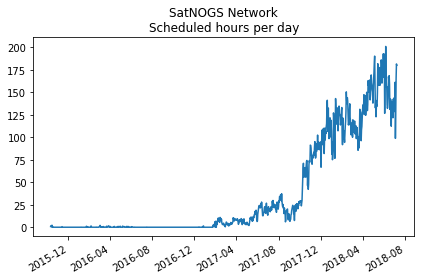

In [8]:
fig, ax = plt.subplots()

access = np.fromiter((d.total_seconds() for d in duration), np.float, len(duration))

ax.plot(days, access/(60*60))

ax.set_title('SatNOGS Network\nScheduled hours per day')
fig.autofmt_xdate()
plt.tight_layout()
fig.savefig('network-obs-access.png', dpi=150)